In [146]:
import pandas as pd
import numpy as np

device = "cpu"
weather_df = pd.read_csv('weather_dataset.csv', sep=',')  # Loading the dataset in a Pandas Dataframe
weather_df


,wind_speed,wind_direction,temperature,dew_point,air_pressure
0,60,260,35,32,10185
1,60,260,36,33,10183
2,60,260,37,34,10181
3,50,260,38,35,10174
4,50,260,39,36,10169
...,...,...,...,...,...
70123,60,250,86,63,10301
70124,50,250,82,65,10299
70125,60,240,82,63,10291
70126,60,250,81,61,10286


In [147]:
for column in weather_df.columns:
  number_of_nans_in_column = weather_df[column].isnull().sum()  # Per ogni colonna, somma il numero dei valori che sono null
  print(f"{column} -> {number_of_nans_in_column} missing values")

wind_speed -> 0 missing values
wind_direction -> 0 missing values
temperature -> 0 missing values
dew_point -> 0 missing values
air_pressure -> 0 missing values


<AxesSubplot:>

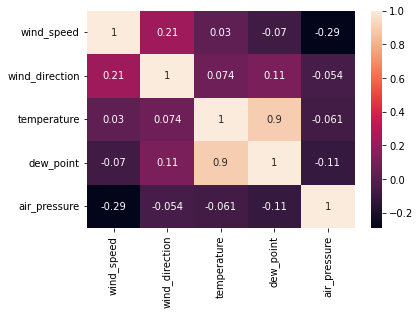

In [148]:
import seaborn as sns

correlations = weather_df.corr() # Calculating the correlations between the columns of the dataset 
sns.heatmap(correlations, annot = True)  # Displaying them in a heatmap

In [149]:
print(list(weather_df.columns))
weather_df = weather_df.drop(columns=['dew_point'])
print(list(weather_df.columns))

['wind_speed', 'wind_direction', 'temperature', 'dew_point', 'air_pressure']
['wind_speed', 'wind_direction', 'temperature', 'air_pressure']


In [150]:
training_set = weather_df[:-168]
test_set = weather_df[-168:]

In [151]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

training_set_scaled = standard_scaler.fit_transform(training_set)
test_set_scaled = standard_scaler.transform(test_set)

print(f"First 10 values in training set before are:\n{training_set.head(10)}\nafter they are:\n{training_set_scaled[:10]}")
print(f"First 10 values in testing set before are:\n{test_set.head(10)}\nafter they are:\n{test_set_scaled[:10]}")

#weather_df = training_set_scaled[0].append(test_set_scaled)
weather_df = np.concatenate((training_set_scaled, test_set_scaled), axis=0)


First 10 values in training set before are:
   wind_speed  wind_direction  temperature  air_pressure
0          60             260           35         10185
1          60             260           36         10183
2          60             260           37         10181
3          50             260           38         10174
4          50             260           39         10169
5          60             260           43         10165
6          60             300           44         10171
7          40             290           40         10174
8          40             300           37         10179
9          30             290           40         10181
after they are:
[[ 0.8001791   0.80484909 -0.97017729  0.34613392]
 [ 0.8001791   0.80484909 -0.95547013  0.32548664]
 [ 0.8001791   0.80484909 -0.94076297  0.30483935]
 [ 0.37388489  0.80484909 -0.92605581  0.23257385]
 [ 0.37388489  0.80484909 -0.91134865  0.18095564]
 [ 0.8001791   0.80484909 -0.85252001  0.13966106]
 [ 0.80

In [152]:
def split_sequence_multi_step(sequence, n_steps_in, n_steps_out):
    """Rolling Window Function for Multi-step"""
    X, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(sequence):
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)[:, :, 0]

seq_length = 3
output_size = 4
x, y = split_sequence_multi_step(weather_df, seq_length, output_size)

In [153]:
from torch import nn

class WeatherCNN(nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, hidden_dim, output_size):
        super(WeatherCNN, self).__init__()

        self.conv1d = torch.nn.Conv1d(input_size, hidden_dim, kernel_size=1)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(batch_size*batch_size*4, 10)
        self.fc2 = torch.nn.Linear(10, output_size)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [154]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

batch_size = 6

def data_loader(x, y, train_split, test_split, batch_size):
    """Prepare data by applying sliding windows and return data loader"""

    # Split to Train, Validation and Test Set #
    train_seq, test_seq, train_label, test_label = train_test_split(x, y, train_size=train_split, shuffle=False)
    val_seq, test_seq, val_label, test_label = train_test_split(test_seq, test_label, train_size=test_split, shuffle=False)

    # Convert to Tensor #
    train_set = TensorDataset(torch.from_numpy(train_seq), torch.from_numpy(train_label))
    val_set = TensorDataset(torch.from_numpy(val_seq), torch.from_numpy(val_label))
    test_set = TensorDataset(torch.from_numpy(test_seq), torch.from_numpy(test_label))

    # Data Loader #
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = data_loader(x, y, len(x)-169, 168, batch_size)
model = WeatherCNN(seq_length, batch_size, output_size).to(device)

In [155]:
# Loss Function #
criterion = torch.nn.MSELoss()

# Optimizer #
optim = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.5, 0.999))

In [156]:
from matplotlib import pyplot as plt
# Lists #
train_losses, val_losses = list(), list()
val_maes, val_mses, val_rmses, val_mapes, val_mpes, val_r2s = list(), list(), list(), list(), list(), list()
test_maes, test_mses, test_rmses, test_mapes, test_mpes, test_r2s = list(), list(), list(), list(), list(), list()
pred_tests, labels = list(), list()

def plot_pred_test(pred, actual, path, feature, model, step):
    """Plot Test set Prediction"""
    plt.figure(figsize=(10, 8))

    plt.plot(pred, label='Pred')
    plt.plot(actual, label='Actual')

    plt.xlabel('Time', fontsize=18)
    plt.ylabel('{}'.format(feature), fontsize=18)

    plt.legend(loc='best')
    plt.grid()

    plt.title('{} Energy Prediction using {} and {}'.format(feature, model.__class__.__name__, step), fontsize=18)
    plt.savefig(os.path.join(path, '{} Energy Prediction using {} and {}.png'.format(feature, model.__class__.__name__, step)))

In [157]:
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Train and Validation #

# Train #
step = "Multistep"
num_epochs = 10
print("Training {} using {} started with total epoch of {}.".format(model.__class__.__name__, step, num_epochs))

for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):

        # Prepare Data #
        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)

        # Forward Data #
        pred = model(data)

        # Calculate Loss #
        train_loss = criterion(pred, label)

        # Initialize Optimizer, Back Propagation and Update #
        optim.zero_grad()
        train_loss.backward()
        optim.step()

        # Add item to Lists #
        train_losses.append(train_loss.item())

    # Print Statistics #
    print("Epoch [{}/{}]".format(epoch+1, num_epochs))
    print("Train Loss {:.4f}".format(np.average(train_losses)))

    # Validation #
    with torch.no_grad():
        for i, (data, label) in enumerate(val_loader):

            # Prepare Data #
            data = data.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.float32)

            # Forward Data #
            pred_val = model(data)

            # Calculate Loss #
            val_loss = criterion(pred_val, label)

            pred_val = np.mean(pred_val.detach().cpu().numpy(), axis=1)
            label = np.mean(label.detach().cpu().numpy(), axis=1)

            # Calculate Metrics #
            val_mae = mean_absolute_error(label, pred_val)
            val_mse = mean_squared_error(label, pred_val, squared=True)
            val_rmse = mean_squared_error(label, pred_val, squared=False)
            val_r2 = r2_score(label, pred_val)

            # Add item to Lists #
            val_losses.append(val_loss.item())
            val_maes.append(val_mae.item())
            val_mses.append(val_mse.item())
            val_rmses.append(val_rmse.item())
            val_r2s.append(val_r2.item())

    if (epoch+1) % 3 == 0:

        # Print Statistics #
        print("Val Loss {:.4f}".format(np.average(val_losses)))
        print(" MAE : {:.4f}".format(np.average(val_maes)))
        print(" MSE : {:.4f}".format(np.average(val_mses)))
        print("RMSE : {:.4f}".format(np.average(val_rmses)))
        print(" MPE : {:.4f}".format(np.average(val_mpes)))
        print("MAPE : {:.4f}".format(np.average(val_mapes)))
        print(" R^2 : {:.4f}".format(np.average(val_r2s)))

    
    # TEST
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):

            # Prepare Data #
            data = data.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.float32)

            # Forward Data #
            pred_test = model(data)

            # Convert to Original Value Range #
            pred_test, label = pred_test.detach().cpu().numpy(), label.detach().cpu().numpy()

            pred_test = standard_scaler.inverse_transform(pred_test)
            label = standard_scaler.inverse_transform(label)

            pred_test = np.mean(pred_test, axis=1)
            label = np.mean(label, axis=1)

            pred_tests += pred_test.tolist()
            labels += label.tolist()

            # Calculate Loss #
            test_mae = mean_absolute_error(label, pred_test)
            test_mse = mean_squared_error(label, pred_test, squared=True)
            test_rmse = mean_squared_error(label, pred_test, squared=False)
            test_r2 = r2_score(label, pred_test)

            # Add item to Lists #
            test_maes.append(test_mae.item())
            test_mses.append(test_mse.item())
            test_rmses.append(test_rmse.item())
            test_r2s.append(test_r2.item())

        # Print Statistics #
        print("Test {} using {}".format(model.__class__.__name__, step))
        print(" MAE : {:.4f}".format(np.average(test_maes)))
        print(" MSE : {:.4f}".format(np.average(test_mses)))
        print("RMSE : {:.4f}".format(np.average(test_rmses)))
        print(" MPE : {:.4f}".format(np.average(test_mpes)))
        print("MAPE : {:.4f}".format(np.average(test_mapes)))
        print(" R^2 : {:.4f}".format(np.average(test_r2s)))

        # Plot Figure #
        plot_pred_test(pred_tests, labels, ".", ["A","B","C","D"], model, step)

Training WeatherCNN using Multistep started with total epoch of 10.


C:\Users\rikyn\miniconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([6, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x120 and 144x10)